In [1]:
from __future__ import division

import pandas as pd
import us

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon

import numpy as np
from collections import Counter
%matplotlib inline

import seaborn as sns

In [2]:
# set the name of the data files
# source: https://homeport.uscg.mil/mycg/portal/ep/contentView.do?channelId=-18374&contentId=166847&programId=91343&programPage=%2Fep%2Fprogram%2Feditorial.jsp&pageTypeId=13489&contentType=EDITORIAL&BV_SessionID=@@@@0013066542.1438924747@@@@&BV_EngineID=ccceadgglljemimcfngcfkmdfhfdfgm.0

data = 'VesDocJul15tab.data'
columns = 'columns.txt'

In [3]:
# read in the column names
colnames = pd.read_table(columns, usecols=[0,], header=None, low_memory=False)[0].tolist()
print(colnames)

# read in the data file
D = pd.read_table(data, header=None, sep='\t', names=colnames, low_memory=False)

# get a subset of only the recreational boats, which will exclude fishing and commercial boats
rec = D[D["Vessel Service Type"] == "Recreational"]

['Vessel ID', 'Vessel Database Key', 'Name of Vessel', 'Call Sign', 'Official Number', 'IMO Number', 'Hull Number', 'Hull Identification Number', 'Vessel Service Type', 'Flag', 'Self Propelled Indicator', 'Registered Gross Tons', 'Registered Net Tons', 'Registered Length', 'Registered Breadth', 'Registered Depth', 'ITC Gross Tons', 'ITC Net Tons', 'Dead Weight Tons', 'Dead Weight Tons Measure Unit', 'ITC Length', 'ITC Breadth', 'ITC Depth', 'Measuring Organization Name', 'Hailing Port', 'Hailing Port State', 'Hailing Port Province', 'Trade Indicator Coastwise Unrestricted', 'Trade Indicator Limited Coastwise Bowaters Only', 'Trade Indicator Limited Coastwise Restricted', 'Trade Indicator Limited Coastwise Oil Spill Response Only', 'Trade Indicator Limited Coastwise Under Charter to Citizen', 'Trade Indicator Limited Coastwise Trade Fish Products', 'Trade Indicator Fishery', 'Trade Indicator Limited Fishery Only', 'Trade Indicator Recreation', 'Trade Indicator Limited Recreation Great L

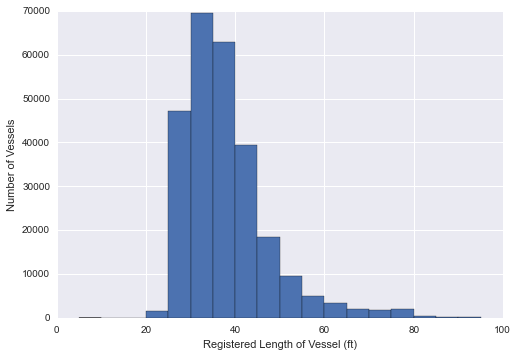

In [4]:
bins = np.arange(5, 100, 5)
ax = rec["Registered Length"].hist(bins=bins)

ax.set_xlabel('Registered Length of Vessel (ft)')
ax.set_ylabel('Number of Vessels')

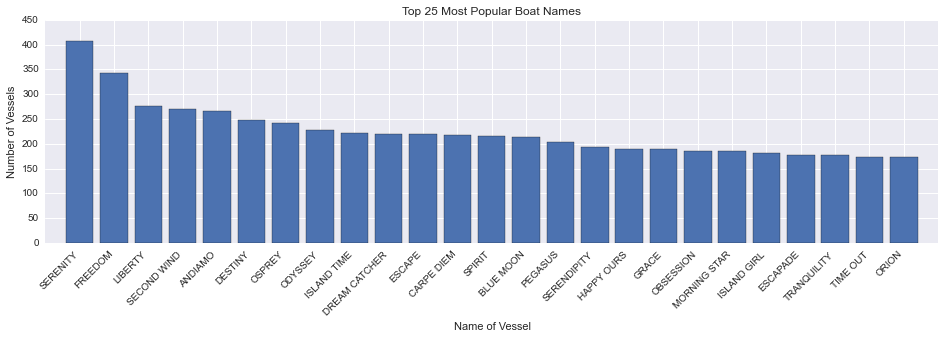

In [5]:
names = [str(i).lower().strip() for i in rec["Name of Vessel"]]
name_counts = Counter(names)

n=25

top_names = name_counts.most_common(n)

fig, ax = plt.subplots(figsize=(16, 4))
xlabs = []
for i, (name, count) in enumerate(top_names):
    xlabs.append(name.upper())
    ax.bar(i, count, align='center')
    
_ = ax.set_xlim(left=-1)
_ = ax.set_xticks(range(n))
_ = ax.set_xticklabels(xlabs, rotation=45, ha='right')
_ = ax.set_xlabel("Name of Vessel")
_ = ax.set_ylabel("Number of Vessels")
_ = ax.set_title("Top {} Most Popular Boat Names".format(n))

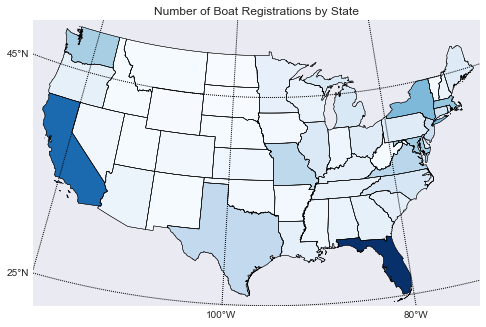

In [9]:
states = rec.groupby("Hailing Port State")["Vessel ID"].count()
# %matplotlib inline

fig, ax = plt.subplots(figsize=(8,8))
# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95,ax=ax)
# draw state boundaries.
# data from U.S Census Bureau
# http://www.census.gov/geo/www/cob/st2000.html
shp_info = m.readshapefile('st99_d00','states',drawbounds=True)

vmin = 0
vmax = states.max()
cmap = plt.cm.Blues # use 'hot' colormap
statenames = []
colors = {}

for shapedict in m.states_info:
    statename = shapedict['NAME']
    # skip DC and Puerto Rico.
    if statename not in ['District of Columbia','Puerto Rico']:
        nboats = states[us.states.lookup(statename).abbr]
        #print(nboats)
        # calling colormap with value between 0 and 1 returns
        # rgba value.  Invert color range (hot colors are high
        # population), take sqrt root to spread out colors more.
        colors[statename] = cmap((nboats-vmin)/(vmax-vmin))[:3]
    statenames.append(statename)
# cycle through state names, color each one.
ax = plt.gca() # get current axes instance
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if statenames[nshape] not in ['District of Columbia','Puerto Rico']:
        color = rgb2hex(colors[statenames[nshape]]) 
        poly = Polygon(seg,facecolor=color)
        ax.add_patch(poly)
# draw meridians and parallels.
_ = m.drawparallels(np.arange(25,65,20),labels=[1,0,0,0])
_ = m.drawmeridians(np.arange(-120,-40,20),labels=[0,0,0,1])

_ = ax.set_title('Number of Boat Registrations by State')
#plt.colorbar()